### ASSESSING WAVELET SCATTERING
___

*Reference: https://www.kymat.io/gallery_1d/plot_real_signal.html#sphx-glr-gallery-1d-plot-real-signal-py*

In [1]:
import os

from spectrai.datasets.kssl import (get_tax_orders_lookup_tbl, get_analytes,
                                    load_data, count_spectra_by_analytes)

from spectrai.vis.spectra import (plot_spectra)

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter, resample

#import torch
#from kymatio import Scattering1D
from kymatio.numpy import Scattering1D

%load_ext autoreload
%autoreload 2
%matplotlib inline  

In [2]:
# Loading Potassium, NH4OAc
X, X_names, y, y_names, instances_id = load_data([723])

In [3]:
print('X shape: ', X.shape)
print('X approx. memory size: {} MB'.format(X.nbytes // 10**6))
print('y approx. memory size: {} MB'.format(y.nbytes // 10**6))
print('Wavenumbers: ', X_names)
print('Target variable: ', y_names)

X shape:  (50714, 1764)
X approx. memory size: 357 MB
y approx. memory size: 1 MB
Wavenumbers:  [3999 3997 3995 ...  603  601  599]
Target variable:  ['lay_depth_to_top' 'order_id' 'calc_value']


In [4]:
spectrum_id = 91
x = X[:,:-1][spectrum_id]

### Utilities functions

In [5]:
def preprocess(x):
    # normalize raw numpy array then convert it to torch tensor
    #x = x.astype(float)
    x /= np.abs(x).max()
    x = x.reshape(1, -1)
    #x = torch.from_numpy(x).float()
    return x

def get_spectrum(X, idx):
    x = X[:,:-1][idx]
    return preprocess(x)

def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return (data_msc, ref)

def vis_scattering(x, x_t, Sx_coeffs, Sx_t_coeffs, label_t = 'Preprocessed signal'):
    fig = plt.figure(constrained_layout=True, figsize=(16, 12))
    gs = fig.add_gridspec(nrows=6, ncols=2)

    ##############################################
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.title.set_text('Original signal')
    ax1.plot(X_names[:-1], x.ravel(), color='firebrick')
    ax1.plot(X_names[:-1], x_t.ravel(), '--', linewidth=1, color='forestgreen')
    ax1.set_frame_on(False)
    ax1.set_xlim(4000, 600)

    #ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.title.set_text(label_t)
    #ax2.plot(X_names[:-1], x.ravel(), '--', linewidth=1, color='black')
    ax2.plot(X_names[:-1], x_t.ravel(), '--', linewidth=1, color='forestgreen')
    ax2.set_frame_on(False)
    ax2.set_xlim(4000, 600)
    #ax2.axis('off')


    ##############################################
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.title.set_text('Low pass filter: zeroth-order scattering')
    ax3.plot(Sx_coeffs[0])
    ax3.set_frame_on(False)
    ax3.set_xlim(0, len(Sx_coeffs[0]))

    ax4 = fig.add_subplot(gs[1, 1], sharex=ax3, sharey=ax3)
    ax4.plot(Sx_t_coeffs[0])
    ax4.axis('off')


    ##############################################
    ax5 = fig.add_subplot(gs[2:4, 0])
    ax5.title.set_text('First-order scattering')
    ax5.imshow(Sx_coeffs[1], aspect='auto')
    ax5.set_frame_on(False)
    #ax5.set_xlim(0, len(Sx_coeffs[1]))
    
    ax6 = fig.add_subplot(gs[2:4, 1], sharex=ax5, sharey=ax5)
    ax6.imshow(Sx_t_coeffs[1], aspect='auto')
    ax6.axis('off')

    ##############################################
    ax7 = fig.add_subplot(gs[4:6, 0])
    ax7.title.set_text('Second-order scattering')
    #ax7.set_xlim(0, len(Sx_coeffs[2]))
    ax7.set_frame_on(False)
    ax7.imshow(Sx_coeffs[2], aspect='auto')

    ax8 = fig.add_subplot(gs[4:6, 1], sharex=ax7, sharey=ax7)
    ax8.imshow(Sx_t_coeffs[2], aspect='auto')
    ax8.axis('off');

def vis_scattering_diff(x, x_t, Sx_coeffs, Sx_t_coeffs, label_t = 'Δs when preprocessed signal'):
    fig = plt.figure(constrained_layout=True, figsize=(16, 10))
    gs = fig.add_gridspec(nrows=6, ncols=2, width_ratios=(9.8, 0.2))
    
    fig.suptitle(label_t, fontsize=16)
    ##############################################
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.title.set_text('Δ signals')
    ax1.plot(X_names[:-1], x.ravel() - x_t.ravel(), color='firebrick')
    #ax1.plot(X_names[:-1], x_t.ravel(), '--', linewidth=1, color='forestgreen')
    ax1.set_frame_on(False)
    ax1.set_xlim(4000, 600)

    ##############################################
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.title.set_text('Δ low pass filter: zeroth-order scattering')
    ax3.plot(Sx_coeffs[0] - Sx_t_coeffs[0])
    ax3.set_frame_on(False)
    ax3.set_xlim(0, len(Sx_coeffs[0]))
        
    ##############################################
    ax5 = fig.add_subplot(gs[2:4, 0])
    ax5.title.set_text('Δ first-order scattering')
    im5 = ax5.imshow(np.abs(Sx_coeffs[1] - Sx_t_coeffs[1]), aspect='auto')
    ax5.set_frame_on(False)
    
    # colorbar
    cax5 = plt.subplot(gs[2:4,1])
    plt.colorbar(im5, cax=cax5, format='%.0e')
    

    ##############################################
    ax7 = fig.add_subplot(gs[4:6, 0])
    ax7.title.set_text('Δ second-order scattering')
    ax7.set_frame_on(False)
    im7 = ax7.imshow(np.abs(Sx_coeffs[2] - Sx_t_coeffs[2]), aspect='auto')
    
    # colorbar
    cax7 = plt.subplot(gs[4:6,1])
    plt.colorbar(im7, cax=cax7, format='%.0e')

    
def get_scattering_coeffs(x, J=4, Q=30):
    T = x.shape[-1]

    scattering = Scattering1D(J, T, Q)
    Sx = scattering(x.ravel())

    meta = scattering.meta()
    order0 = np.where(meta['order'] == 0)
    order1 = np.where(meta['order'] == 1)
    order2 = np.where(meta['order'] == 2)
    return [Sx[order0][0], Sx[order1], Sx[order2]]

def get_analyte(y, names, name):
    list(y_names).index(name)
    return y[:,list(y_names).index(name)]

In [6]:
x = preprocess(x)

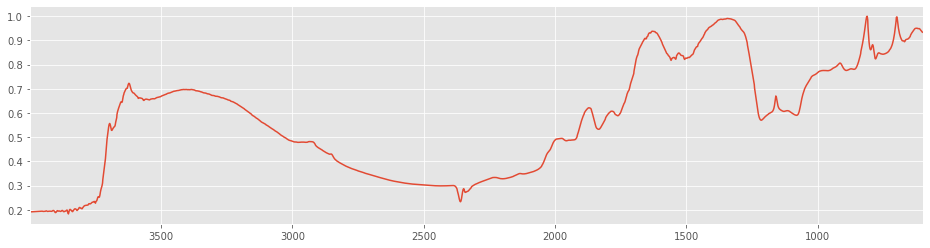

In [7]:
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(16,4))
    ax.set_xlim(X_names[0], X_names[-1])
    _ = ax.plot(X_names[:-1], x.ravel())

In [8]:
T = x.shape[-1]
J = 4
Q = 1

scattering = Scattering1D(J, T, Q, out_type='list', average=True)
Sx = scattering(x.ravel())

In [181]:
len(Sx[0]['coef'])

111

In [182]:
for l in Sx:
    print(l['j'])

()
(0,)
(0,)
(0,)
(1,)
(2,)
(0, 1)
(0, 2)
(0, 1)
(0, 2)
(0, 1)
(0, 2)
(1, 2)


In [17]:
T = x.shape[-1]
J = 5
Q = 24

scattering = Scattering1D(J, T, Q, average=True)
Sx = scattering(x.ravel())

meta = scattering.meta()
order0 = np.where(meta['order'] == 0)
order1 = np.where(meta['order'] == 1)
order2 = np.where(meta['order'] == 2)

In [191]:
order2

(array([ 6,  7,  8,  9, 10, 11, 12]),)

In [82]:
?Scattering1D

In [171]:
Sx.shape

(29, 111)

In [192]:
Sx

array([[4.18582124e-02, 4.19421228e-02, 4.21340762e-02, ...,
        4.57202660e-01, 4.52467318e-01, 4.50659028e-01],
       [1.69233478e-05, 2.33591252e-05, 3.91213510e-05, ...,
        7.96875855e-04, 5.74918194e-04, 4.82533326e-04],
       [3.73393898e-05, 5.31284741e-05, 9.17969441e-05, ...,
        1.98594279e-03, 1.39408612e-03, 1.15239791e-03],
       ...,
       [5.67687077e-06, 7.84355555e-06, 1.22447004e-05, ...,
        8.59267395e-04, 5.78233060e-04, 4.57377430e-04],
       [3.00916086e-06, 3.65618005e-06, 5.00007419e-06, ...,
        7.43299962e-04, 5.60403636e-04, 4.85119739e-04],
       [1.19203462e-06, 1.18167330e-06, 1.19981063e-06, ...,
        5.98483950e-04, 4.97987807e-04, 4.55023170e-04]])

In [165]:
meta.keys()

dict_keys(['order', 'xi', 'sigma', 'j', 'n', 'key'])

In [193]:
meta['j']

array([[nan, nan],
       [ 0., nan],
       [ 0., nan],
       [ 0., nan],
       [ 1., nan],
       [ 2., nan],
       [ 0.,  1.],
       [ 0.,  2.],
       [ 0.,  1.],
       [ 0.,  2.],
       [ 0.,  1.],
       [ 0.,  2.],
       [ 1.,  2.]])

In [167]:
meta['j'][order2,:]

array([[[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]]])

In [194]:
meta['n']

array([[nan, nan],
       [ 0., nan],
       [ 1., nan],
       [ 2., nan],
       [ 3., nan],
       [ 4., nan],
       [ 0.,  3.],
       [ 0.,  4.],
       [ 1.,  3.],
       [ 1.,  4.],
       [ 2.,  3.],
       [ 2.,  4.],
       [ 3.,  4.]])

In [187]:
meta

{'order': array([0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]),
 'xi': array([[     nan,      nan],
        [0.35    ,      nan],
        [0.175   ,      nan],
        [0.0875  ,      nan],
        [0.04375 ,      nan],
        [0.021875,      nan],
        [0.35    , 0.04375 ],
        [0.35    , 0.021875],
        [0.175   , 0.04375 ],
        [0.175   , 0.021875],
        [0.0875  , 0.04375 ],
        [0.0875  , 0.021875],
        [0.04375 , 0.021875]]),
 'sigma': array([[       nan,        nan],
        [0.14013095,        nan],
        [0.07006547,        nan],
        [0.03503274,        nan],
        [0.01751637,        nan],
        [0.00875818,        nan],
        [0.14013095, 0.01751637],
        [0.14013095, 0.00875818],
        [0.07006547, 0.01751637],
        [0.07006547, 0.00875818],
        [0.03503274, 0.01751637],
        [0.03503274, 0.00875818],
        [0.01751637, 0.00875818]]),
 'j': array([[nan, nan],
        [ 0., nan],
        [ 0., nan],
        [ 0., nan],
      

In [9]:
order0

(array([0]),)

In [15]:
order1

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),)

In [16]:
Sx.shape

(77, 111)

In [17]:
order2

(array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
        50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
        67, 68, 69, 70, 71, 72, 73, 74, 75, 76]),)

In [18]:
Sx

array([[7.31772114e-02, 7.35397266e-02, 7.44376771e-02, ...,
        7.23420287e-01, 7.31446072e-01, 7.34896349e-01],
       [8.91249240e-07, 8.23252950e-07, 7.25565769e-07, ...,
        2.31393373e-05, 3.16884331e-05, 3.52023585e-05],
       [1.20076228e-06, 1.09474030e-06, 8.74463176e-07, ...,
        2.23849613e-05, 3.05147043e-05, 3.38463808e-05],
       ...,
       [2.32657259e-07, 2.93338873e-07, 4.44941316e-07, ...,
        7.37089442e-06, 7.53087855e-06, 7.56737605e-06],
       [6.79800590e-07, 7.04401438e-07, 7.90190226e-07, ...,
        1.03419884e-05, 1.02430897e-05, 1.01928647e-05],
       [4.36257502e-07, 4.58495181e-07, 5.15186448e-07, ...,
        2.04973125e-05, 2.29033176e-05, 2.39763016e-05]])

In [95]:
T = x.shape[1]

In [21]:
2**J

16

In [22]:
T/2**J

110.1875

In [23]:
Sx[order0].shape

(1, 111)

In [24]:
len(Sx[order0][0])

111

Text(0.5, 1.0, 'Second-order scattering')

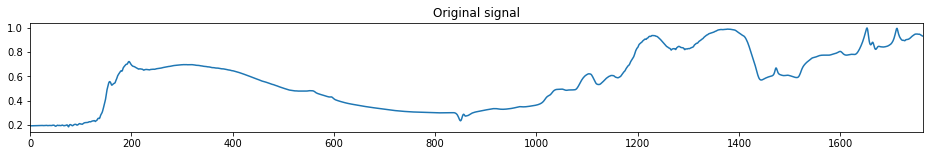

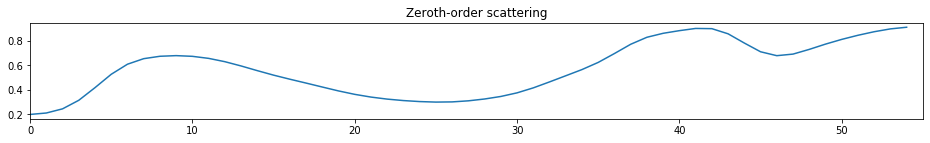

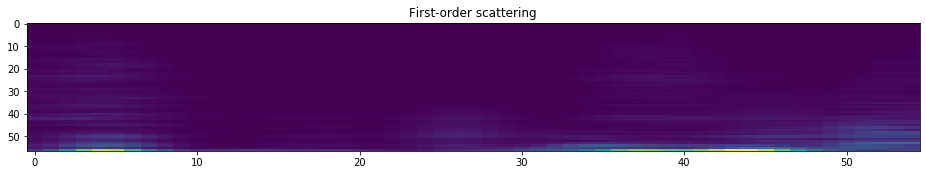

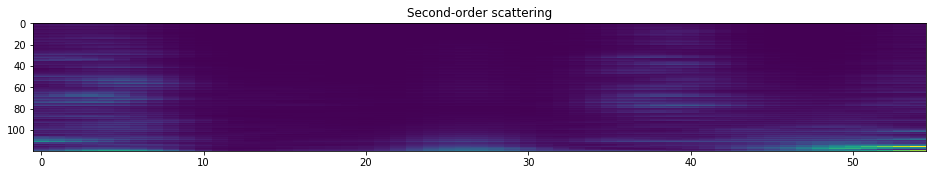

In [18]:
plt.figure(figsize=(16, 2))
plt.plot(x.ravel())
plt.xlim(0, len(x.ravel()))
plt.title('Original signal')

plt.figure(figsize=(16, 6))
plt.subplot(3, 1, 1)
plt.plot(Sx[order0][0])
plt.xlim(0, len(Sx[order0][0]))
plt.title('Zeroth-order scattering')

plt.figure(figsize=(16, 8))
plt.subplot(3, 1, 2)
plt.imshow(Sx[order1], aspect='auto')
plt.title('First-order scattering')

plt.figure(figsize=(16, 8))
plt.subplot(3, 1, 3)
plt.imshow(Sx[order2], aspect='auto')
plt.title('Second-order scattering')

In [198]:
x.shape[1] / 2**4

110.1875

In [98]:
Sx[order2].shape

(124, 27)

In [99]:
nb_features = len(Sx[order2].ravel()) + len(Sx[order1].ravel()) + len(Sx[order0][0])
print('Number of features: ', nb_features)

Number of features:  4779


In [100]:
np.max(Sx[order1].ravel())

0.0033600103663709766

In [106]:
1e-4

0.0001

In [105]:
sum(Sx[order1].ravel() > 1e-4)

383

In [25]:
Sx[order2].ravel().shape

(4884,)

In [26]:
Sx[order1].ravel().shape

(3552,)

In [27]:
Sx[order0].ravel()

array([-0.56295313, -0.56199964, -0.55958231, -0.55584964, -0.54998151,
       -0.53910287, -0.51574132, -0.46505528, -0.37083501, -0.23518727,
       -0.09057585,  0.01873993,  0.06785328,  0.06462288,  0.03885939,
        0.01812363,  0.01222627,  0.01721345,  0.02605256,  0.03397111,
        0.03903471,  0.0414394 ,  0.04239511,  0.04268468,  0.04169404,
        0.03760404,  0.02840212,  0.01280976, -0.00929758, -0.03680837,
       -0.06756616, -0.09895837, -0.12878469, -0.15597846, -0.18066146,
       -0.20348993, -0.22501985, -0.24552026, -0.26487668, -0.28261999,
       -0.29833165, -0.31196681, -0.32372424, -0.33369961, -0.34173501,
       -0.34765013, -0.3516058 , -0.35441313, -0.35751087, -0.3623165 ,
       -0.37023059, -0.38269596, -0.39691452, -0.40228871, -0.38993949,
       -0.36498803, -0.34124388, -0.32716281, -0.3212128 , -0.31642572,
       -0.30605256, -0.28441878, -0.24560469, -0.18839262, -0.12327368,
       -0.06626968, -0.02282722,  0.0135241 ,  0.04420894,  0.06

In [28]:
coeffs_0 = Sx[order0].ravel()
coeffs_1 = Sx[order1].ravel()
coeffs_2 = Sx[order2].ravel()
coeffs_all = np.r_[Sx[order0].ravel(), Sx[order1].ravel(), Sx[order2].ravel()]

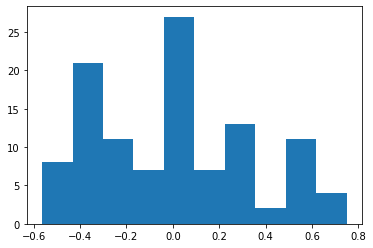

In [29]:
# the histogram of the data
plt.hist(coeffs_0);

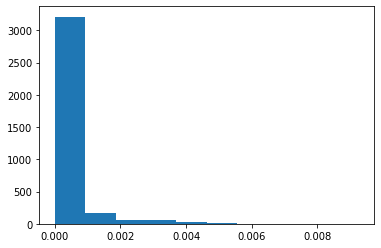

In [30]:
plt.hist(coeffs_1);

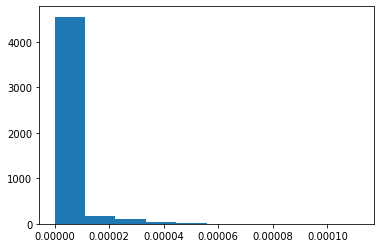

In [31]:
plt.hist(coeffs_2);

In [32]:
len(coeffs_0)

111

In [33]:
len(coeffs_1)

3552

In [34]:
len(coeffs_2)

4884

In [35]:
np.sum(coeffs_1>0.002)

151

In [36]:
np.sum(coeffs_2>0.00002)

180

In [37]:
np.quantile(coeffs_2, 0.9)

7.0419799797763734e-06

In [38]:
np.sum(coeffs_1 > np.quantile(coeffs_1, 0.95))

178

In [39]:
np.sum(coeffs_2 > np.quantile(coeffs_2, 0.95))

245

### Plot the 1D filters coefficients

In [39]:
from kymatio.scattering1d.filter_bank import scattering_filter_factory

In [40]:
T = 2**11 # 2**11 closest power of 2 to our signal support
J = 6
Q = 14

In [41]:
print('Length of signal: ', T)
print('Largest filter at a time interval of: ', 2**J)
print('Number of wavelets per octave: ', Q)

Length of signal:  2048
Largest filter at a time interval of:  64
Number of wavelets per octave:  14


In [42]:
phi_f, psi1_f, psi2_f, _ = scattering_filter_factory(np.log2(T), J, Q)

In [43]:
len(phi_f[0][phi_f[0] > 0.0001])

27

In [44]:
phi_f[0][:31]

array([1.00000000e+00, 9.52344800e-01, 8.22577562e-01, 6.44388725e-01,
       4.57833362e-01, 2.95022656e-01, 1.72421624e-01, 9.13937554e-02,
       4.39369336e-02, 1.91571718e-02, 7.57567744e-03, 2.71706473e-03,
       8.83826307e-04, 2.60748785e-04, 6.97695772e-05, 1.69316124e-05,
       3.72665317e-06, 7.43923132e-07, 1.34686969e-07, 2.21162518e-08,
       3.29371411e-09, 4.44885965e-10, 5.45004313e-11, 6.05535492e-12,
       6.10193668e-13, 5.57678908e-14, 4.62263041e-15, 3.47522200e-16,
       2.36954175e-17, 1.46532718e-18, 8.21851355e-20])

Text(0.5, 1.0, 'First-order filters (Q = 14)')

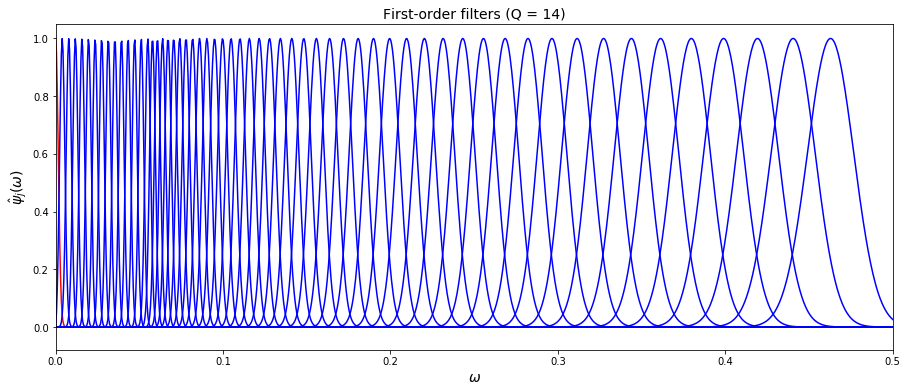

In [45]:
plt.figure(figsize=(15,6))
plt.plot(np.arange(T)/T, phi_f[0], 'r')

for psi_f in psi1_f:
    plt.plot(np.arange(T)/T, psi_f[0], 'b')

plt.xlim(0, 0.5)

plt.xlabel(r'$\omega$', fontsize=14)
plt.ylabel(r'$\hat\psi_j(\omega)$', fontsize=14)
plt.title('First-order filters (Q = {})'.format(Q), fontsize=14)

### Wavelet scattering and preprocessing

#### 1. Scattering the scattering correction

**Correcting scattering effects in NIR**

*Source:  https://nirpyresearch.com/two-scatter-correction-techniques-nir-spectroscopy-python/*

NIR spectra contain a mix of diffuse and specular reflectance (or straight transmittance).  Three main factors affecting the shape of each spectrum are:

1. Different wavelengths of the incident light experience different absorption by the sample, due to the chemical nature of the sample itself. In most cases this is the signal we want to measure, and it relates to the analyte of interest.
2. Differences in particle size in the material will cause light to be deviated at different angles depending on its wavelength. Scattering effects (particle size), along with possible differences in path length constitute the major causes of variations in NIR spectra.
3. Path length differences from sample to sample due to variations in positioning and/or irregularities in the sample surface.
Scattering effects can be both additive and multiplicative. Additive effects (such as path length differences) produce a baseline displacement of the spectrum along the vertical axis, while multiplicative effects (particle size for instance)  modify the local slope of the spectrum.

The idea behind scattering corrections is to get rid of all effects that are unrelated to the chemical nature of the sample, but just depend on the sample morphology and the measurement geometry.  So, the idea goes, if we are able to remove these undesirable effects beforehand, we should get a better model for the quantity of interest.

As always, that is easier said than done. In practice it may be extremely difficult to separate scattering from absorbance effects, and the methods developed by the community tend to be approximations that are valid under specific assumptions.

Having said that however, years of practice showed that both MSC and SNV often do a good job in improving the quality of the calibration model and indeed are two of the most common, yet simple, pre-processing techniques for NIR data.

In [20]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return (data_msc, ref)

In [21]:
# Apply MSC correction
X_msc = msc(X)[0]

In [26]:
spectrum_id = 91
J = 5 # Default 4 - when J increases, it decreases time resolution and have more translation-invariant properties
Q = 12 # Default 30

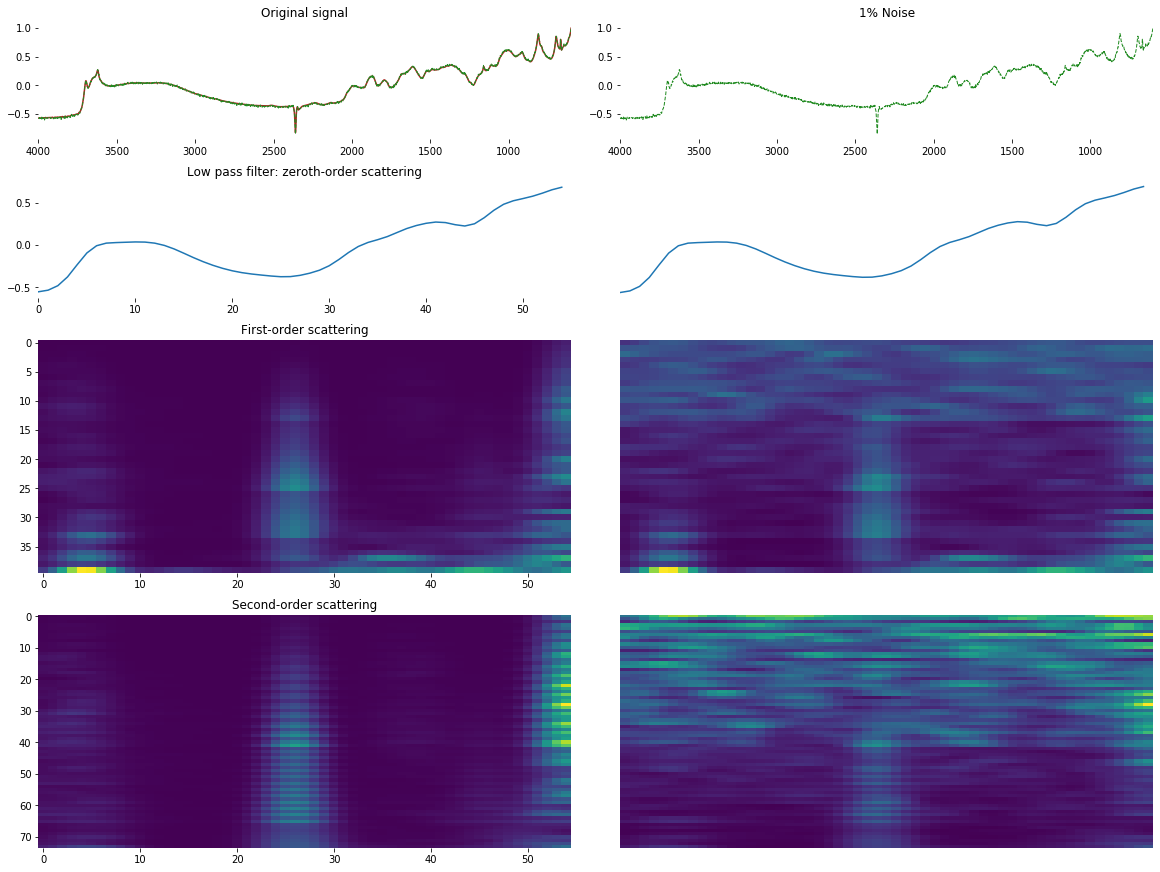

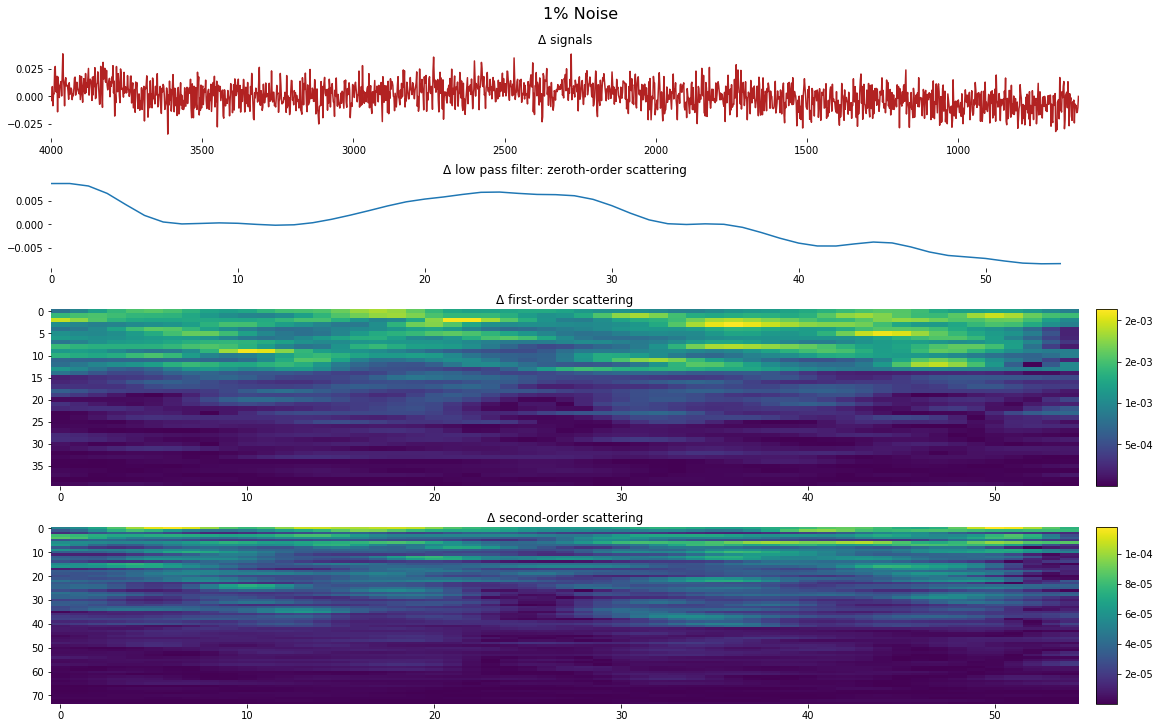

In [24]:
# Noise
X_t = np.copy(X) + 0.01*np.random.randn(X.shape[1])
x = get_spectrum(X, spectrum_id)
x_t = get_spectrum(X_t, spectrum_id)
Sx_coeffs = get_scattering_coeffs(x, J=J, Q=Q)
Sx_t_coeffs = get_scattering_coeffs(x_t, J=J, Q=Q)

vis_scattering(x, x_t, Sx_coeffs, Sx_t_coeffs, label_t='1% Noise')
vis_scattering_diff(x, x_t, Sx_coeffs, Sx_t_coeffs, label_t='1% Noise')

In [37]:
x_t[0].shape

(1762,)

In [45]:
def delta(s0, s1):
    return np.sum(np.abs(s0 - s1))/len(s0)

In [55]:
for x0, x1 in [(x[0], x_t[0]), (Sx_coeffs[0], Sx_t_coeffs[0]), (Sx_coeffs[1], Sx_t_coeffs[1]), (Sx_coeffs[2], Sx_t_coeffs[2])]:
    print('MAE: ', delta(x0, x1))

MAE:  0.009222776721066323
MAE:  0.003955207645525769
MAE:  0.030190888367012225
MAE:  0.0012522641471939828


In [46]:
delta(x[0], x_t[0])

0.009222776721066323

In [47]:
delta(Sx_coeffs[0], Sx_t_coeffs[0])

0.003955207645525769

In [48]:
delta(Sx_coeffs[1], Sx_t_coeffs[1])

0.030190888367012225

In [49]:
delta(Sx_coeffs[2], Sx_t_coeffs[2])

0.0012522641471939828

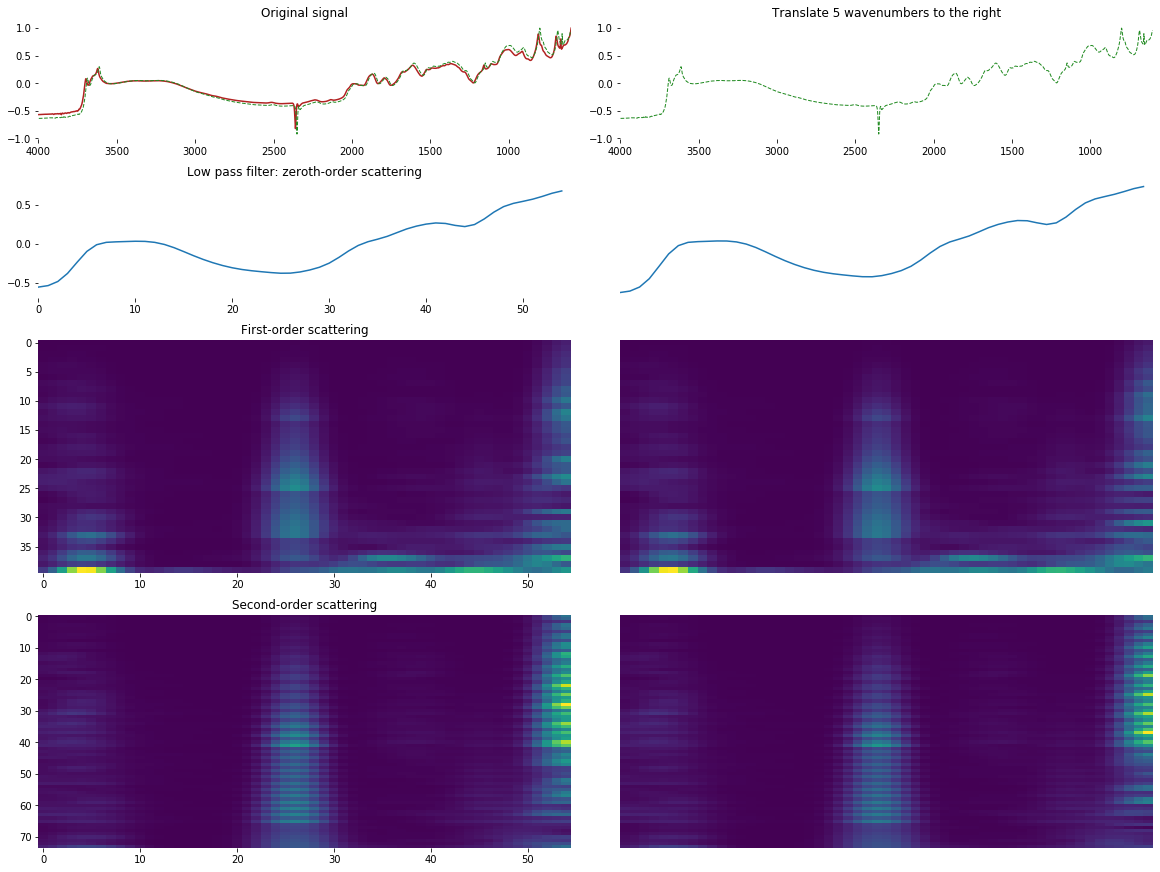

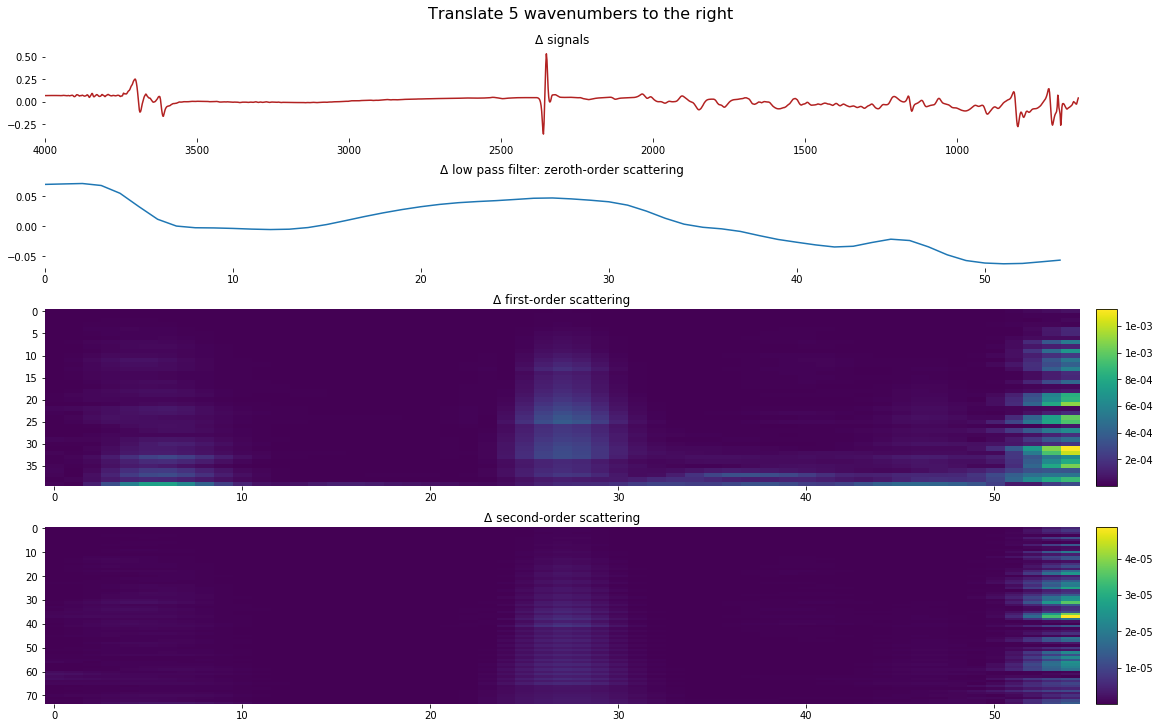

In [56]:
# Translation
shift = 5
X_t = np.roll(X, shift)
X_t[:,:shift] = X_t[:,shift].reshape(1,-1).T

x = get_spectrum(X, spectrum_id)
x_t = get_spectrum(X_t, spectrum_id)
Sx_coeffs = get_scattering_coeffs(x, J=J, Q=Q)
Sx_t_coeffs = get_scattering_coeffs(x_t, J=J, Q=Q)

vis_scattering(x, x_t, Sx_coeffs, Sx_t_coeffs, label_t='Translate {} wavenumbers to the right'.format(shift))
vis_scattering_diff(x, x_t, Sx_coeffs, Sx_t_coeffs, label_t='Translate {} wavenumbers to the right'.format(shift))

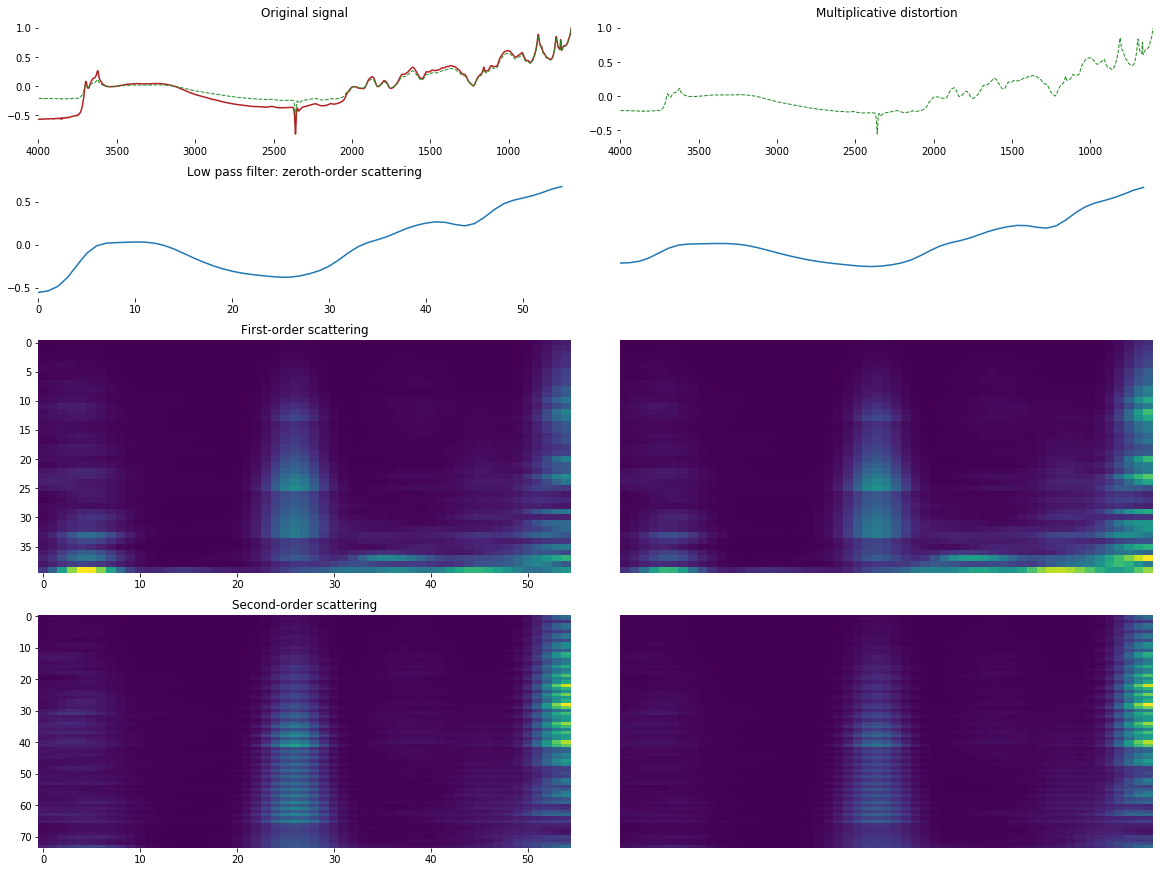

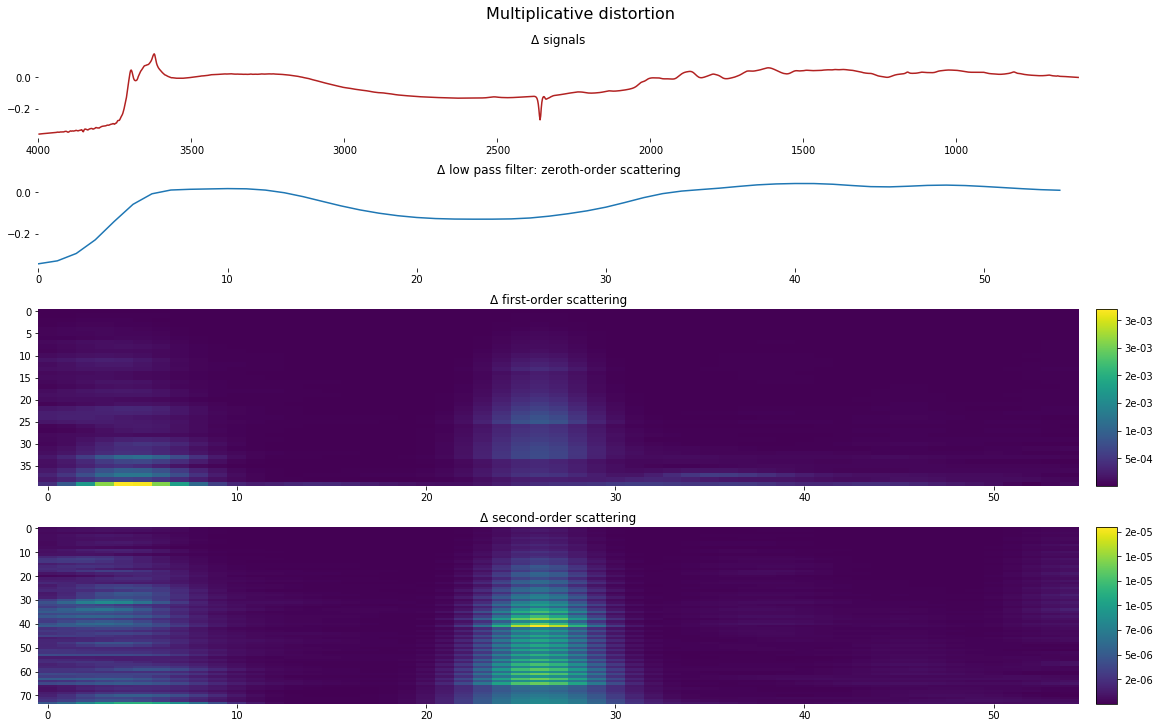

In [45]:
# Multiplicative
X_t = np.copy(X) * np.linspace(1.1, 3, num=X.shape[1])

x = get_spectrum(X, spectrum_id)
x_t = get_spectrum(X_t, spectrum_id)
Sx_coeffs = get_scattering_coeffs(x, J=J, Q=Q)
Sx_t_coeffs = get_scattering_coeffs(x_t, J=J, Q=Q)

vis_scattering(x, x_t, Sx_coeffs, Sx_t_coeffs, label_t='Multiplicative distortion')
vis_scattering_diff(x, x_t, Sx_coeffs, Sx_t_coeffs, label_t='Multiplicative distortion')

In [57]:
for x0, x1 in [(x[0], x_t[0]), (Sx_coeffs[0], Sx_t_coeffs[0]), (Sx_coeffs[1], Sx_t_coeffs[1]), (Sx_coeffs[2], Sx_t_coeffs[2])]:
    print('MAE: ', delta(x0, x1))

MAE:  0.04189116080692218
MAE:  0.031152702181595184
MAE:  0.0029535276397632754
MAE:  5.031382045170147e-05


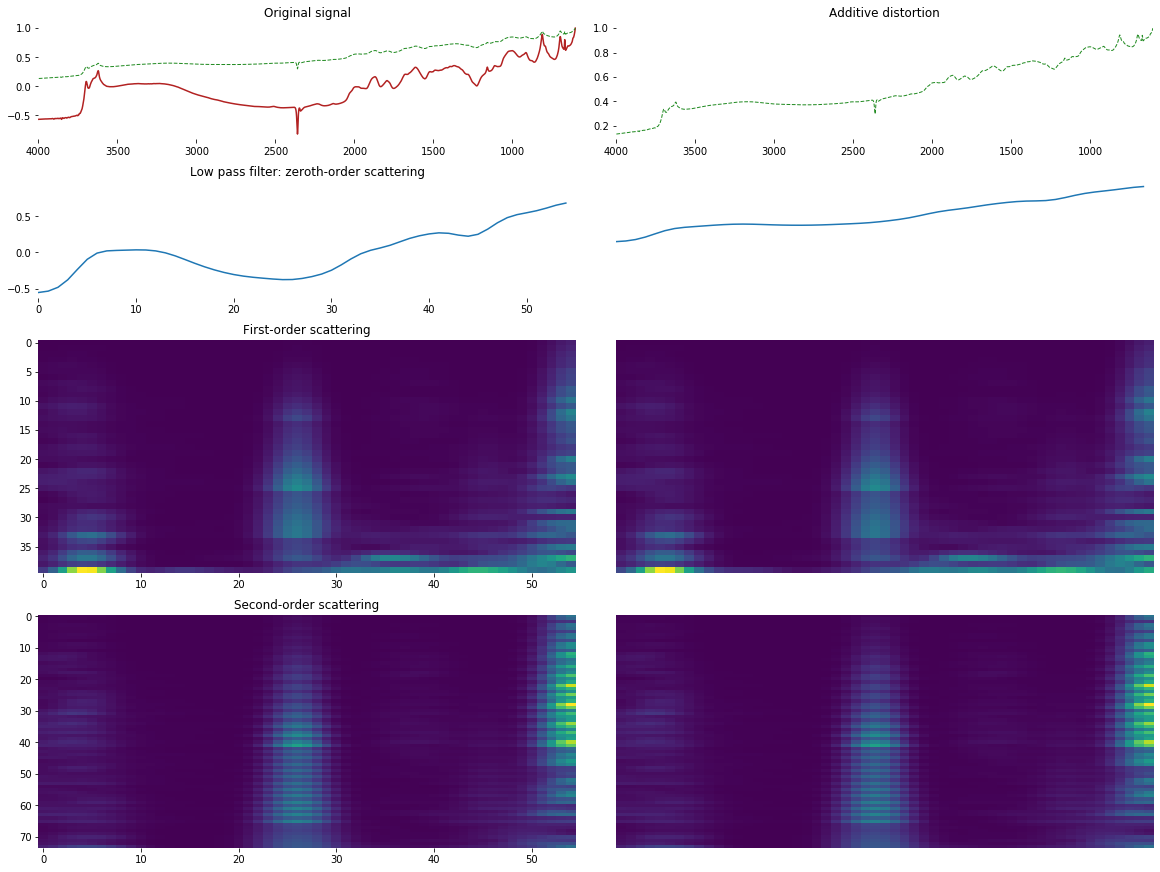

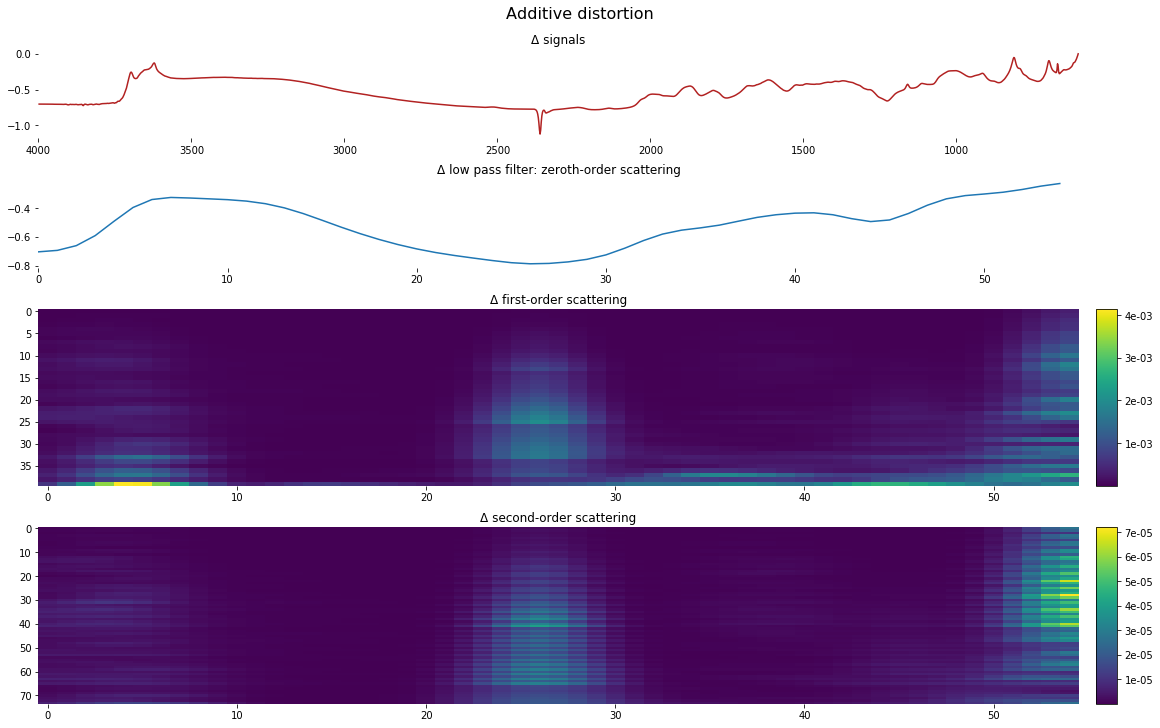

In [66]:
# Additive
X_t = np.copy(X) + np.linspace(1.1, 3, num=X.shape[1])

x = get_spectrum(X, spectrum_id)
x_t = get_spectrum(X_t, spectrum_id)
Sx_coeffs = get_scattering_coeffs(x, J=J, Q=Q)
Sx_t_coeffs = get_scattering_coeffs(x_t, J=J, Q=Q)

vis_scattering(x, x_t, Sx_coeffs, Sx_t_coeffs, label_t='Additive distortion')
vis_scattering_diff(x, x_t, Sx_coeffs, Sx_t_coeffs, label_t='Additive distortion')

In [67]:
for x0, x1 in [(x[0], x_t[0]), (Sx_coeffs[0], Sx_t_coeffs[0]), (Sx_coeffs[1], Sx_t_coeffs[1]), (Sx_coeffs[2], Sx_t_coeffs[2])]:
    print('MAE: ', delta(x0, x1))

MAE:  0.5139880951648649
MAE:  0.5139726056360518
MAE:  0.015282657728250012
MAE:  0.0002431098382036631


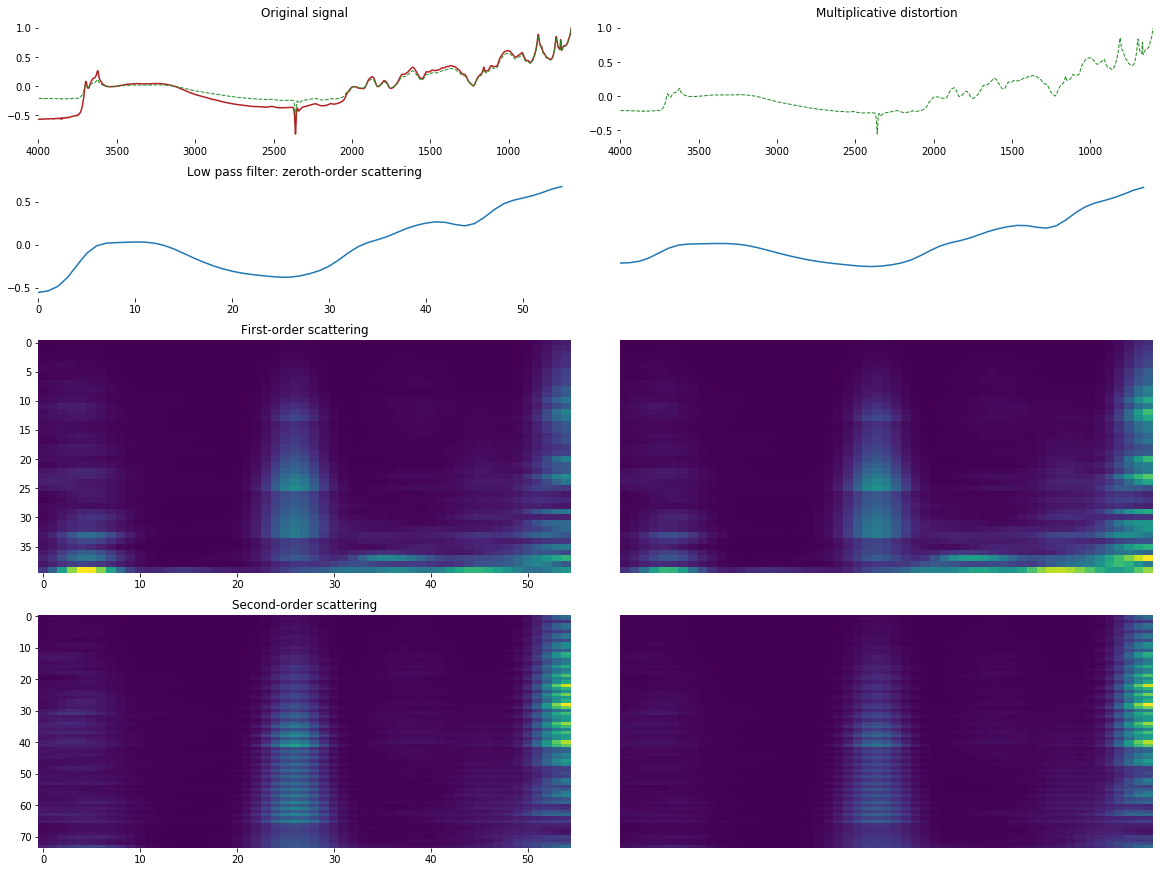

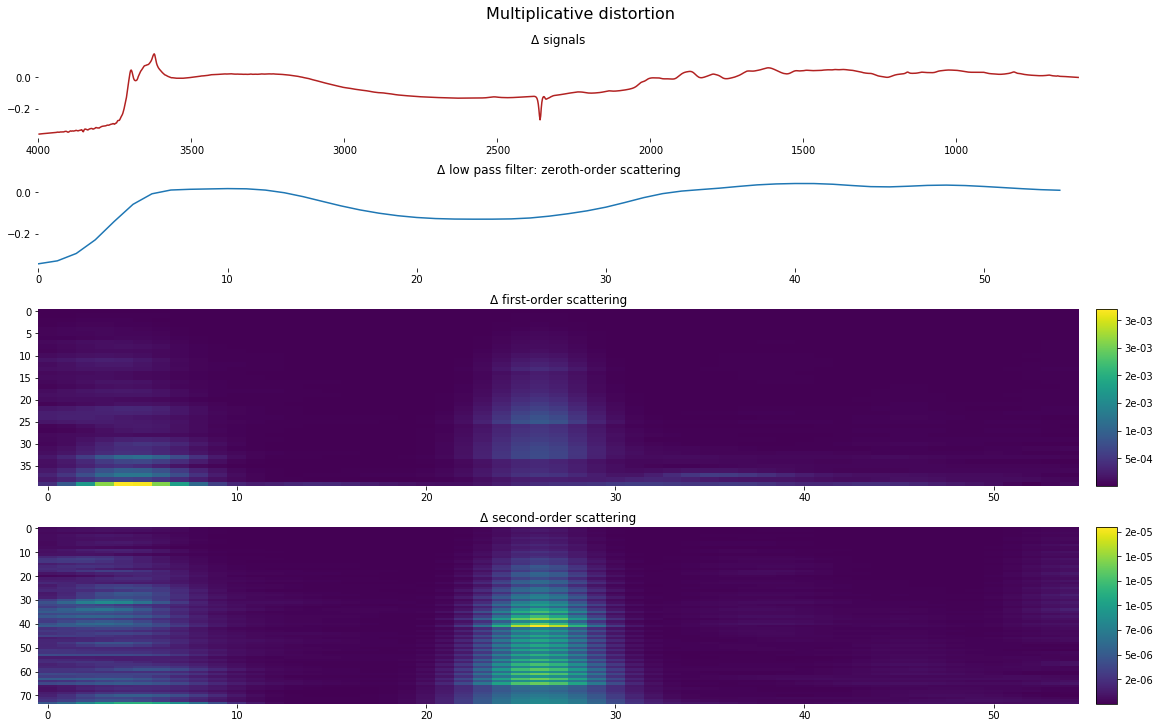

In [58]:
# Multiplicative
X_t = np.copy(X) * np.linspace(1.1, 3, num=X.shape[1])

x = get_spectrum(X, spectrum_id)
x_t = get_spectrum(X_t, spectrum_id)
Sx_coeffs = get_scattering_coeffs(x, J=J, Q=Q)
Sx_t_coeffs = get_scattering_coeffs(x_t, J=J, Q=Q)

vis_scattering(x, x_t, Sx_coeffs, Sx_t_coeffs, label_t='Multiplicative distortion')
vis_scattering_diff(x, x_t, Sx_coeffs, Sx_t_coeffs, label_t='Multiplicative distortion')

In [59]:
for x0, x1 in [(x[0], x_t[0]), (Sx_coeffs[0], Sx_t_coeffs[0]), (Sx_coeffs[1], Sx_t_coeffs[1]), (Sx_coeffs[2], Sx_t_coeffs[2])]:
    print('MAE: ', delta(x0, x1))

MAE:  0.07513761998477363
MAE:  0.06950663011357376
MAE:  0.00518740664417829
MAE:  7.018893616278611e-05


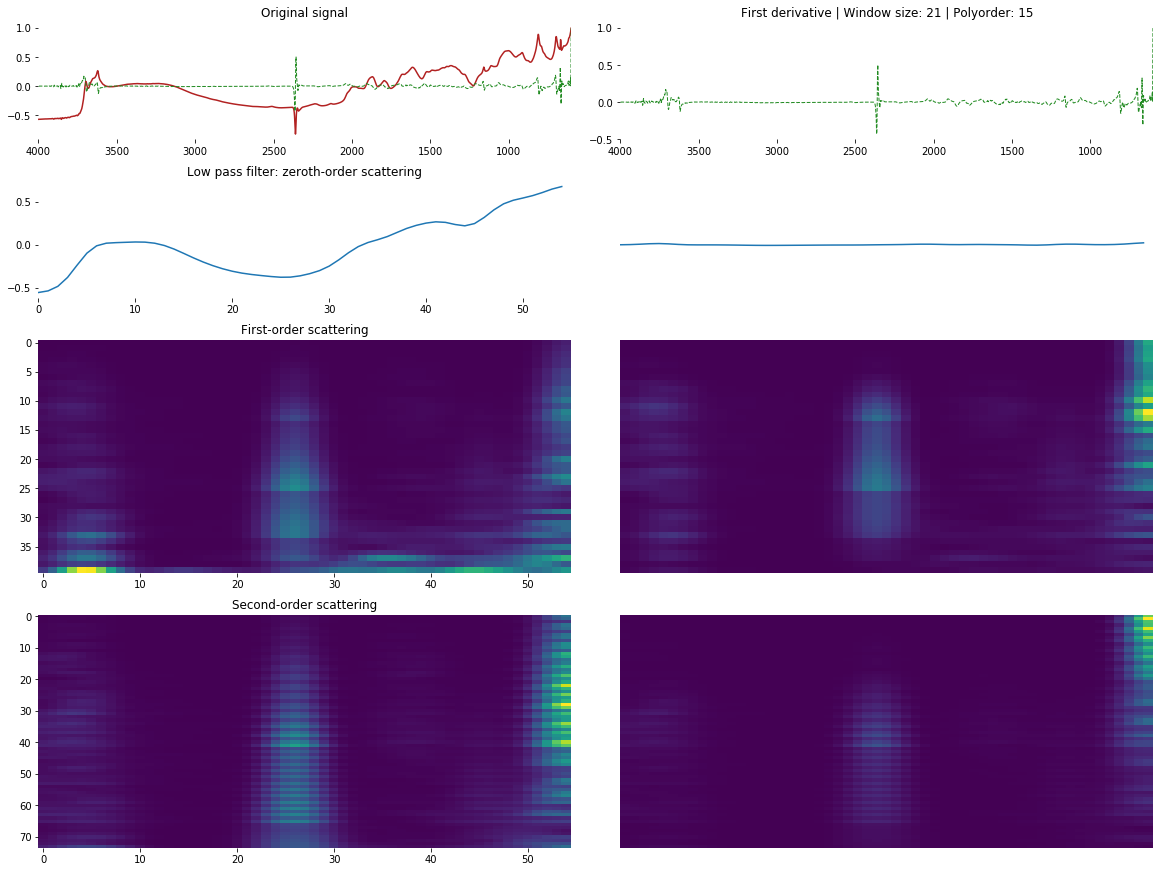

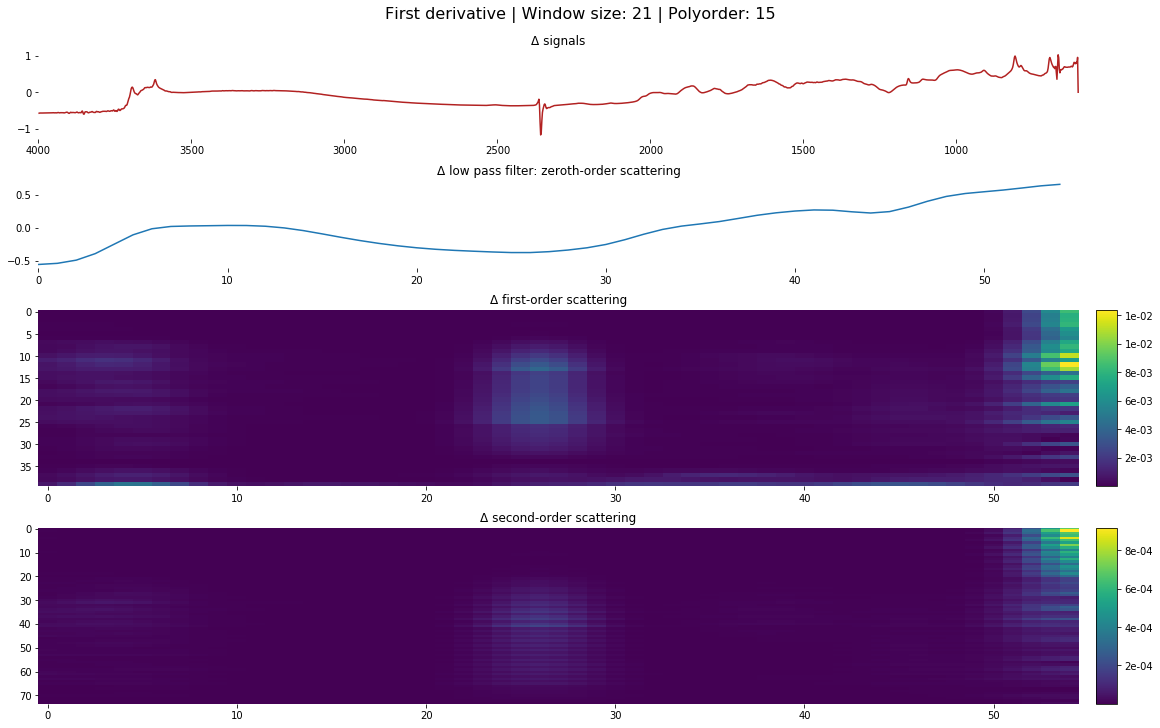

In [47]:
# 1st derivative
X_t = savgol_filter(X, 21, polyorder = 15, deriv=1)
x = get_spectrum(X, spectrum_id)
x_t = get_spectrum(X_t, spectrum_id)
Sx_coeffs = get_scattering_coeffs(x, J=J, Q=Q)
Sx_t_coeffs = get_scattering_coeffs(x_t, J=J, Q=Q)

vis_scattering(x, x_t, Sx_coeffs, Sx_t_coeffs, label_t='First derivative | Window size: 21 | Polyorder: 15')
vis_scattering_diff(x, x_t, Sx_coeffs, Sx_t_coeffs, label_t='First derivative | Window size: 21 | Polyorder: 15')

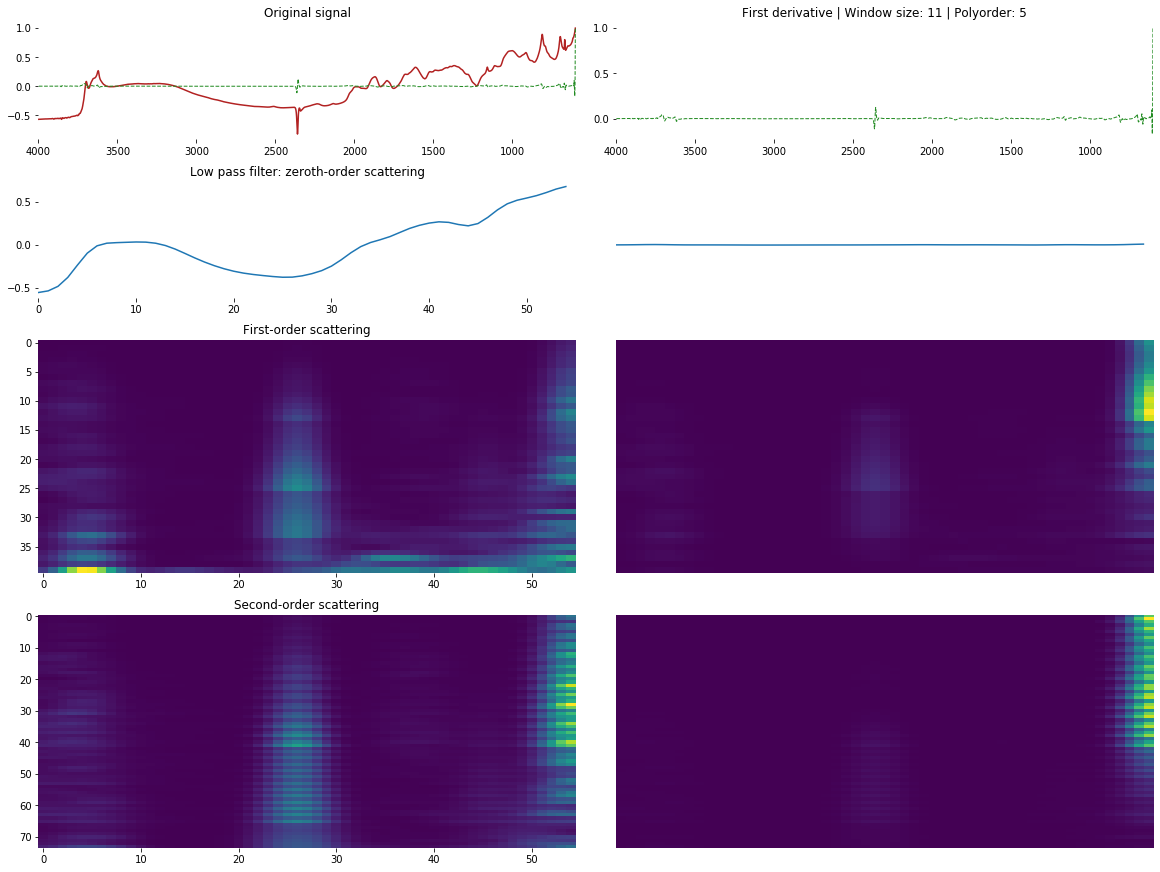

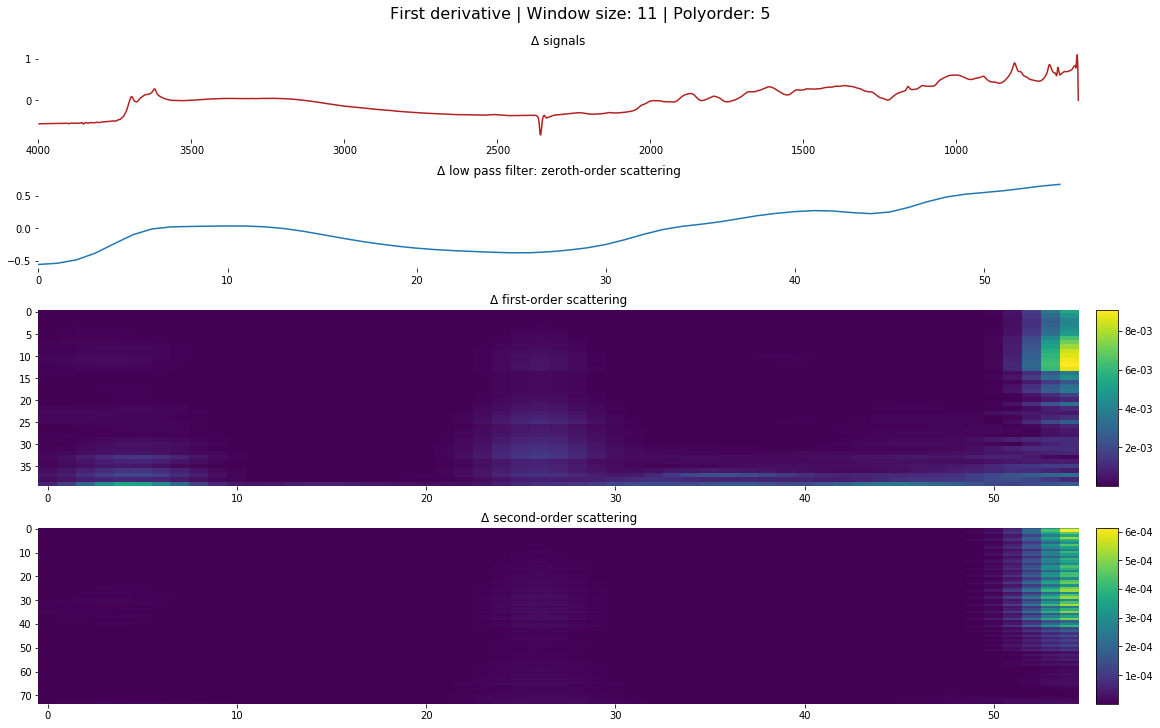

In [48]:
# 1st derivative
X_t = savgol_filter(X, 11, polyorder = 5, deriv=1)
x = get_spectrum(X, spectrum_id)
x_t = get_spectrum(X_t, spectrum_id)

Sx_coeffs = get_scattering_coeffs(x, J=J, Q=Q)
Sx_t_coeffs = get_scattering_coeffs(x_t, J=J, Q=Q)

vis_scattering(x, x_t, Sx_coeffs, Sx_t_coeffs, label_t='First derivative | Window size: 11 | Polyorder: 5')
vis_scattering_diff(x, x_t, Sx_coeffs, Sx_t_coeffs, label_t='First derivative | Window size: 11 | Polyorder: 5')

In [60]:
# Effect of replicates
DATA_PATH = os.path.join('..', 'data')
VIETNAM_PATH =  os.path.join('vnm-petra', 'vietnam-petra')
DATA_URL = os.path.join(DATA_PATH, VIETNAM_PATH, '*.0')

df_petra_rep = spa.load_spectra_petra_rep(DATA_URL)

In [61]:
df_petra_rep.head()

,3179,3180,3181,3182,3183,3184,3185,3186,3187,3188,...,4912,4913,4914,4915,4916,4917,4918,4919,4920,4921
wavenumber,,,,,,,,,,,,,,,,,,,,,
3997.754689,-0.058851,-0.070614,-0.054410,-0.017036,-0.032874,-0.024359,-0.091122,-0.016153,-0.003196,-0.179961,...,-0.163059,-0.143101,-0.176583,-0.155702,-0.121631,-0.166089,-0.098744,-0.036523,-0.191762,-0.112193
3995.826201,-0.058633,-0.070425,-0.054260,-0.016834,-0.032688,-0.024157,-0.090900,-0.015950,-0.002959,-0.179763,...,-0.162956,-0.142935,-0.176453,-0.155582,-0.121484,-0.165978,-0.098600,-0.036496,-0.191582,-0.112051
3993.897714,-0.058434,-0.070294,-0.054170,-0.016678,-0.032460,-0.024002,-0.090624,-0.015780,-0.002748,-0.179531,...,-0.162822,-0.142715,-0.176281,-0.155439,-0.121303,-0.165808,-0.098417,-0.036408,-0.191369,-0.111887
3991.969226,-0.058272,-0.070153,-0.054037,-0.016518,-0.032181,-0.023809,-0.090358,-0.015603,-0.002515,-0.179266,...,-0.162611,-0.142506,-0.176085,-0.155255,-0.121098,-0.165618,-0.098242,-0.036316,-0.191181,-0.111736
3990.040739,-0.057997,-0.069773,-0.053719,-0.016262,-0.031732,-0.023421,-0.089922,-0.015246,-0.002090,-0.178832,...,-0.162359,-0.142300,-0.175850,-0.155033,-0.120873,-0.165410,-0.098025,-0.036213,-0.190992,-0.111561


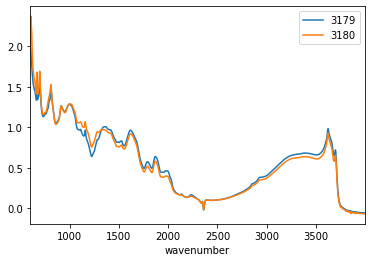

In [62]:
df_petra_rep[[3179, 3180]].plot()

In [63]:
X_replicates = df_petra_rep[[3179, 3180]].to_numpy().T

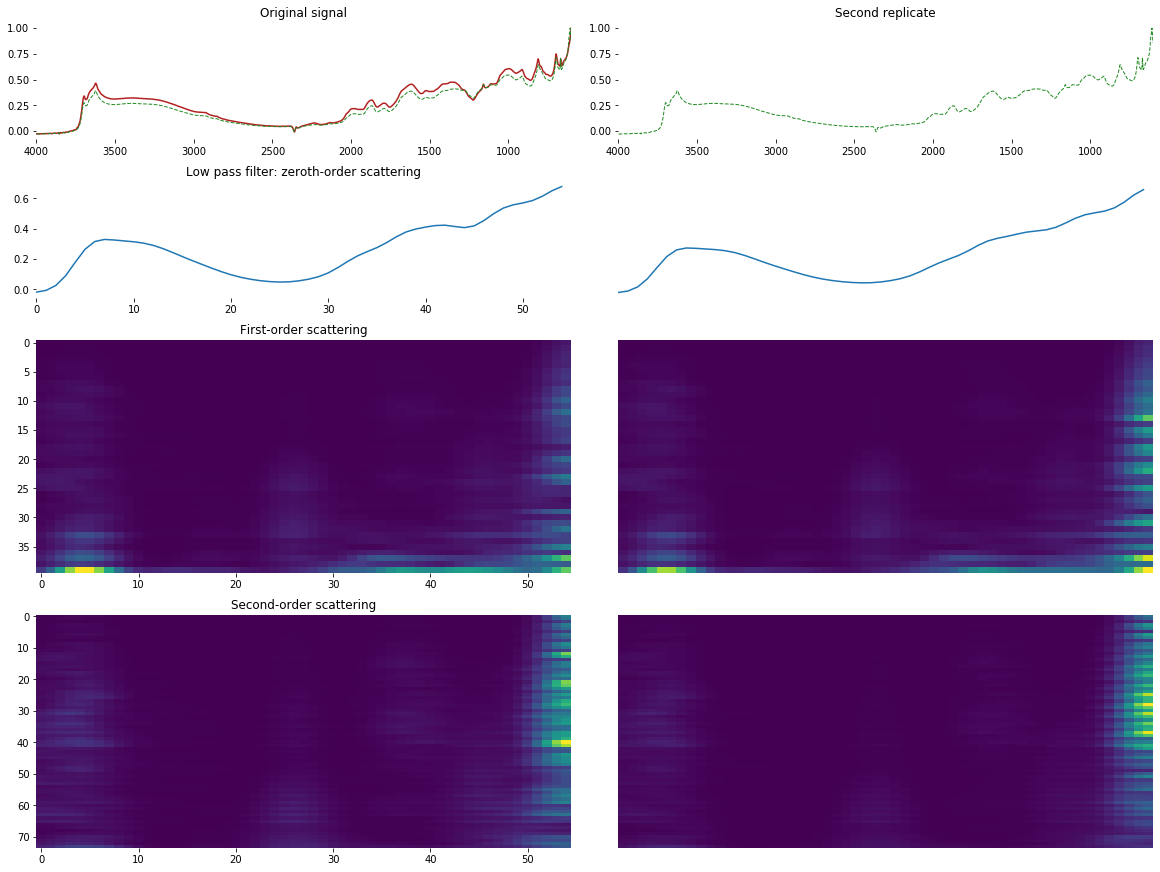

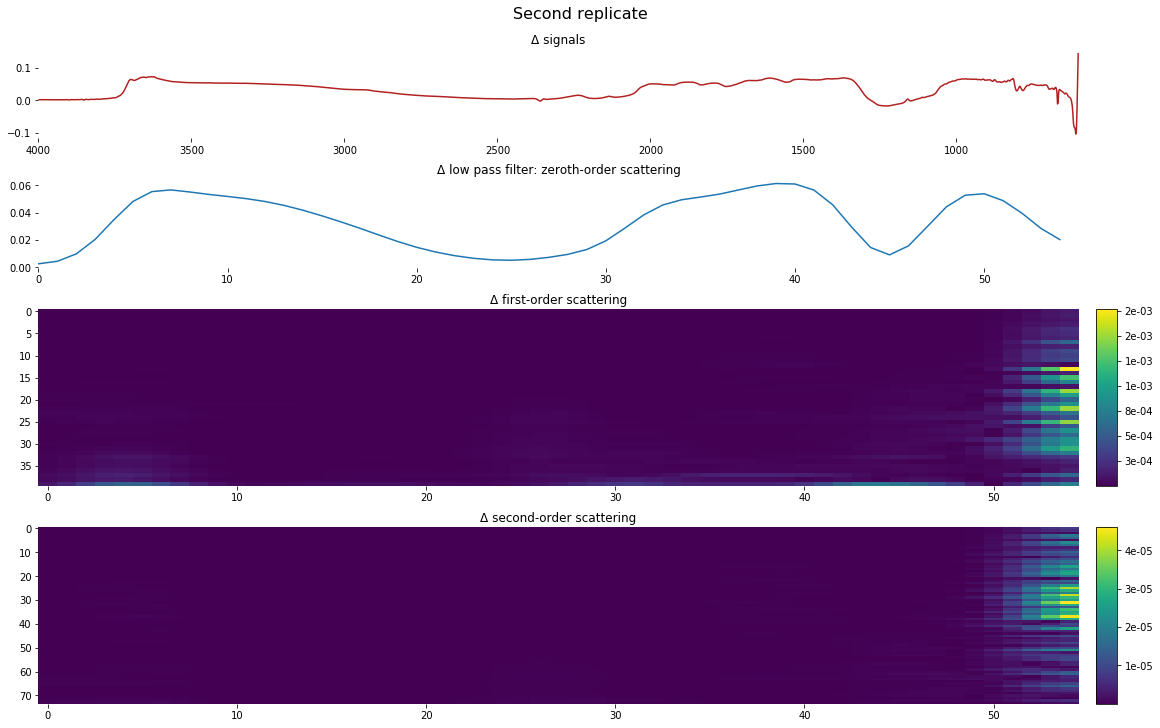

In [64]:
# Replicates
X_replicates = df_petra_rep[[3179, 3180]].to_numpy().T
x = get_spectrum(X_replicates, 0)
x_t = get_spectrum(X_replicates, 1)

Sx_coeffs = get_scattering_coeffs(x, J=J, Q=Q)
Sx_t_coeffs = get_scattering_coeffs(x_t, J=J, Q=Q)

vis_scattering(x, x_t, Sx_coeffs, Sx_t_coeffs, label_t='Second replicate')
vis_scattering_diff(x, x_t, Sx_coeffs, Sx_t_coeffs, label_t='Second replicate')

In [65]:
for x0, x1 in [(x[0], x_t[0]), (Sx_coeffs[0], Sx_t_coeffs[0]), (Sx_coeffs[1], Sx_t_coeffs[1]), (Sx_coeffs[2], Sx_t_coeffs[2])]:
    print('MAE: ', delta(x0, x1))

MAE:  0.034667366870010784
MAE:  0.03312113070499383
MAE:  0.002297607863958862
MAE:  4.4583984922479624e-05


### Wavelet scattering and analyte max change

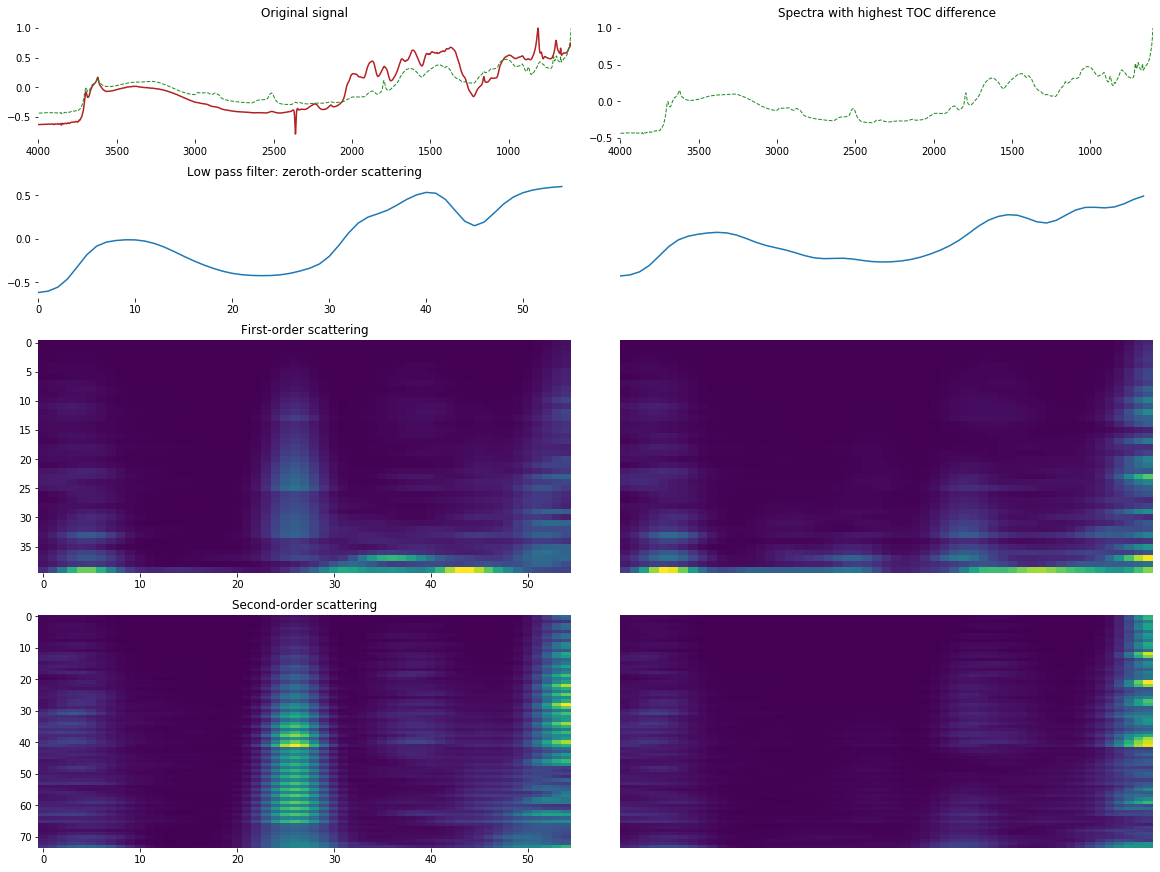

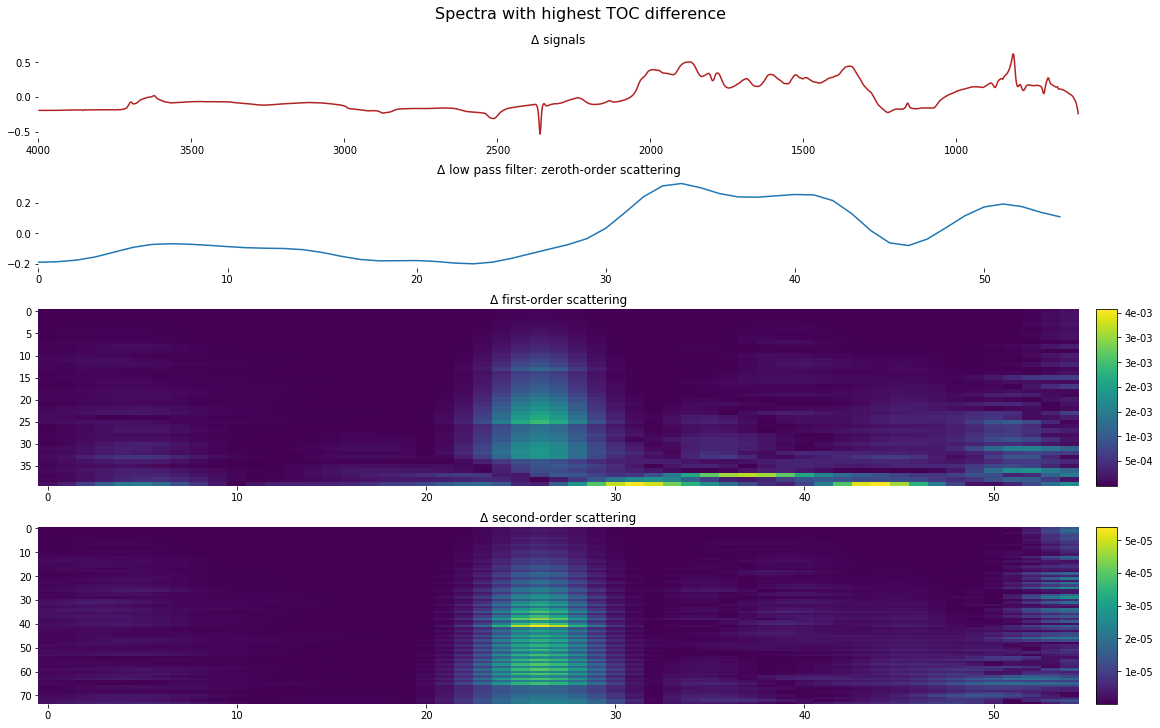

In [54]:
# Comparing Spectrum for highest and lowest values of TOC
y_toc = get_analyte(y, y_names, 'TOC')

min_idx, max_idx = (np.argmin(y_toc, axis=0), np.argmax(y_toc, axis=0))


X_min_max = X[[min_idx, max_idx],:]
x = get_spectrum(X_min_max, 0)
x_t = get_spectrum(X_min_max, 1)

Sx_coeffs = get_scattering_coeffs(x, J=J, Q=Q)
Sx_t_coeffs = get_scattering_coeffs(x_t, J=J, Q=Q)

vis_scattering(x, x_t, Sx_coeffs, Sx_t_coeffs, label_t='Spectra with highest TOC difference')
vis_scattering_diff(x, x_t, Sx_coeffs, Sx_t_coeffs, label_t='Spectra with highest TOC difference')

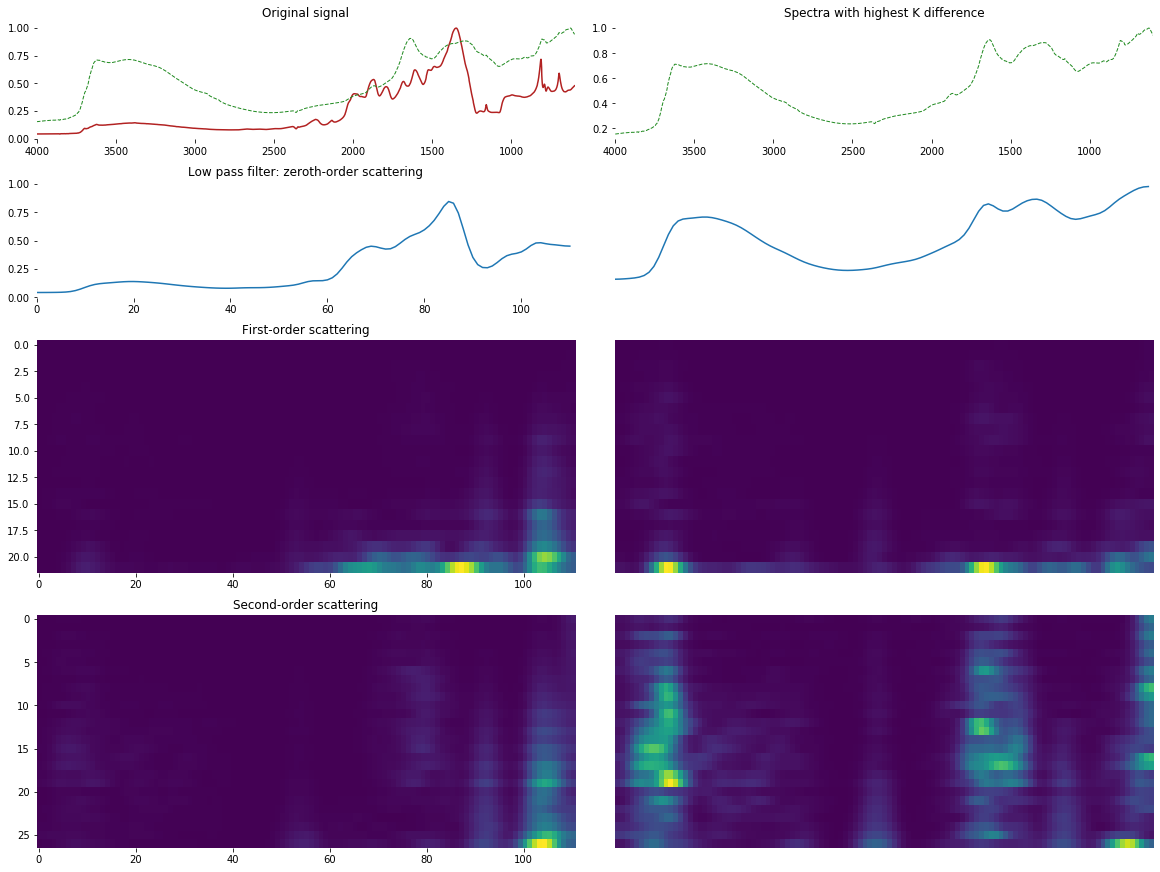

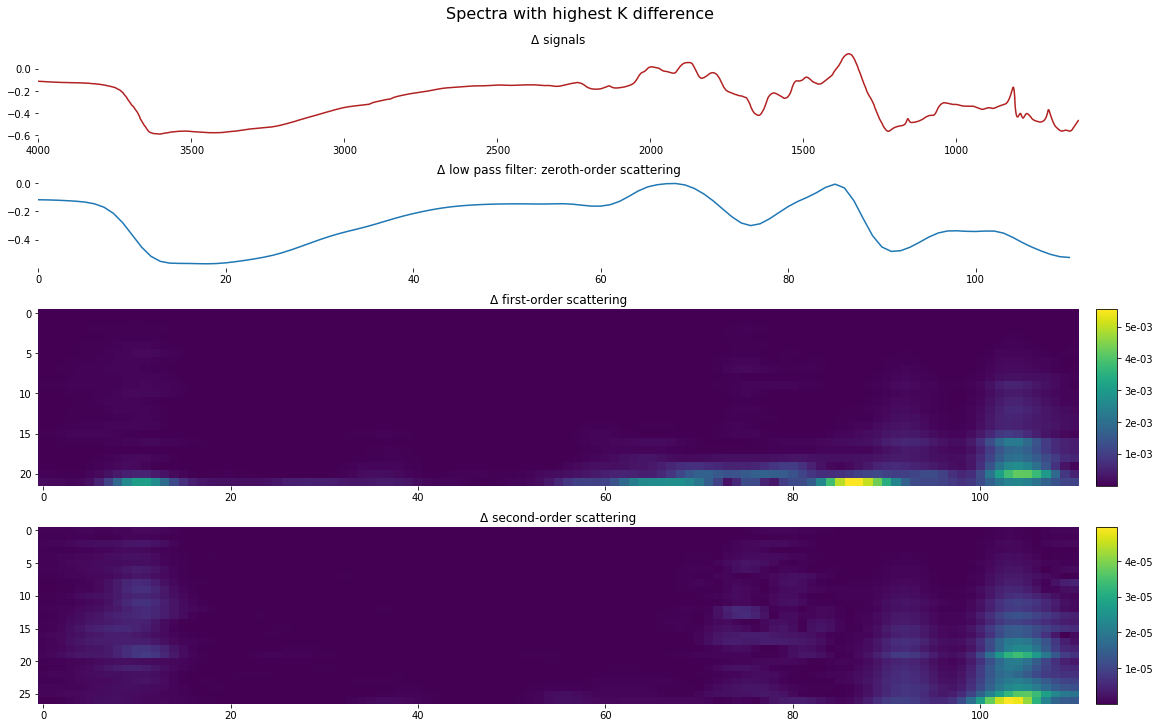

In [209]:
# Comparing Spectrum for highest and lowest values of K
#y_K = get_analyte(y, y_names, 'K')

J = 4
Q = 8
min_idx, max_idx = (np.nanargmin(y[:, -1], axis=0), np.nanargmax(y[:, -1], axis=0))

X_min_max = X[[min_idx, max_idx],:]
x = get_spectrum(X_min_max, 0)
x_t = get_spectrum(X_min_max, 1)

Sx_coeffs = get_scattering_coeffs(x, J=J, Q=Q)
Sx_t_coeffs = get_scattering_coeffs(x_t, J=J, Q=Q)

vis_scattering(x, x_t, Sx_coeffs, Sx_t_coeffs, label_t='Spectra with highest K difference')
vis_scattering_diff(x, x_t, Sx_coeffs, Sx_t_coeffs, label_t='Spectra with highest K difference')

### Wavelet scattering tweaking

In [130]:
spectrum_id = 91
J = 4 # Default 4 - when J increases, it decreases time resolution and have more translation-invariant properties
Q = 12 # Default 30

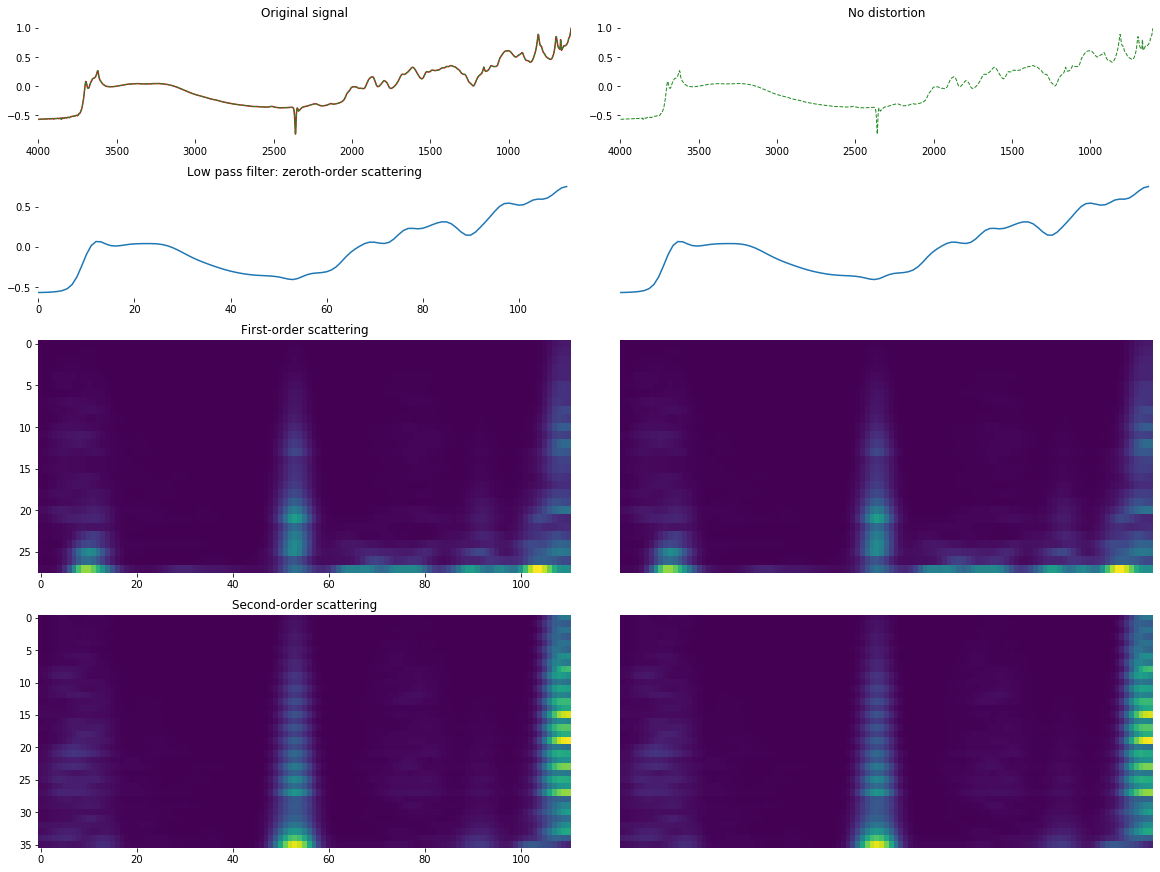

In [131]:

#X_t = np.copy(X) + 0.01*np.random.randn(X.shape[1])
x = get_spectrum(X, spectrum_id)
#x_t = get_spectrum(X_t, spectrum_id)
Sx_coeffs = get_scattering_coeffs(x, J=J, Q=Q)
#Sx_t_coeffs = get_scattering_coeffs(x_t, J=J, Q=Q)

vis_scattering(x, x, Sx_coeffs, Sx_coeffs, label_t='No distortion')
#vis_scattering_diff(x, x_t, Sx_coeffs, Sx_t_coeffs, label_t='1% Noise')

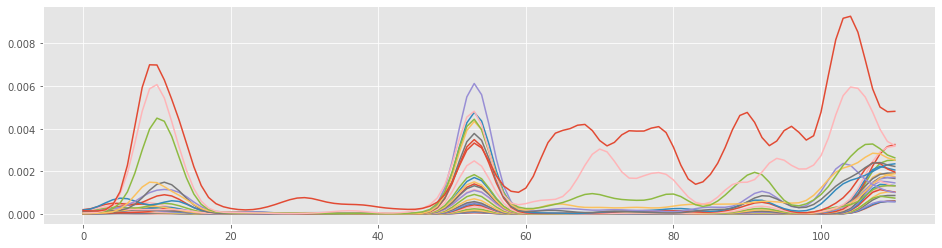

In [122]:
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(16,4))
    #ax.set_ylim(0, 0.006)
    _ = ax.plot(Sx_coeffs[1].T)

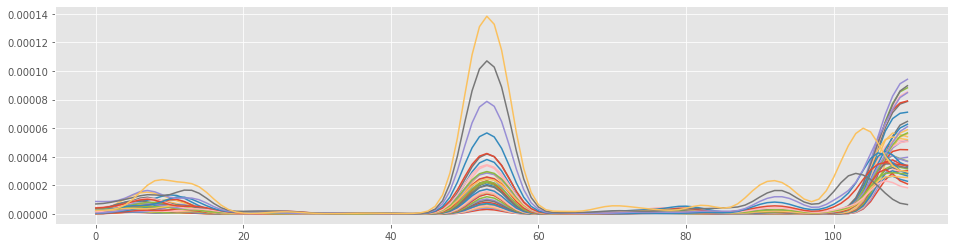

In [123]:
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(16,4))
    #ax.set_xlim(4000, 600)
    _ = ax.plot(Sx_coeffs[2].T)